In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns 

# Linear Regression

Read in data: 

In [23]:
embeddings = pd.read_pickle('/vol/data/ouologuems/systems_genetics/data/datasets/phase3_top10/embeddings_complete.pickle') 
sample_id = []
gene_id = []
embedding = []
for i in range(0, len(embeddings), 2):
    sid = embeddings[i][0].split(':')[1]
    gid = embeddings[i][0].split(':')[2]
    sample_id.append(sid)
    gene_id.append(gid)
    combined_embedding = embeddings[i][1] + embeddings[i+1][1]  # sum embedding
    embedding.append(combined_embedding)
df = pd.DataFrame({"sample_id": sample_id, "gene_id": gene_id, "embedding": embedding})
expression = pd.read_csv("/vol/data/ouologuems/systems_genetics/data/datasets/GD660.GeneQuantRPKM.txt", sep="\t")
expression = expression[expression["Gene_Symbol"].isin(df["gene_id"].values)]
expression = pd.melt(expression, id_vars=["TargetID", "Gene_Symbol", "Chr", "Coord"], var_name="sample_id", value_name="expression")
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0] + "." + expression["sample_id"].str.split(".", expand=True)[1]
test_set = pd.read_csv("/vol/data/ouologuems/systems_genetics/data/datasets/phase3_top10/test_set_indices.tsv", sep = "\t")
expression.loc[expression.sample_id.isin(test_set.sample_id) & expression.Gene_Symbol.isin(test_set.seg_name), "test_set"] = True
expression["sample_id"] = expression["sample_id"].str.split(".", expand=True)[0]
data = pd.merge(df, expression, left_on=["sample_id", "gene_id"], right_on=["sample_id", "Gene_Symbol"])

### **Run linear regression on all genes**

In [34]:
from sklearn.model_selection import cross_val_score

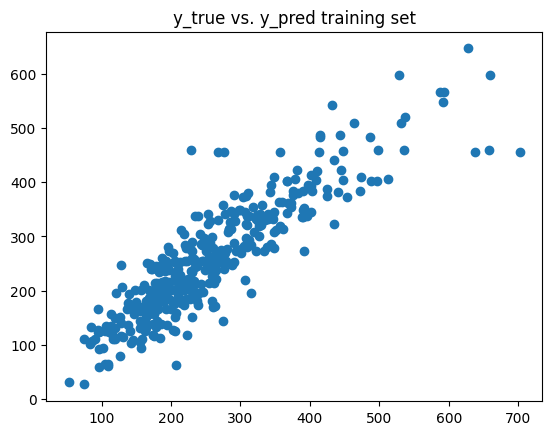

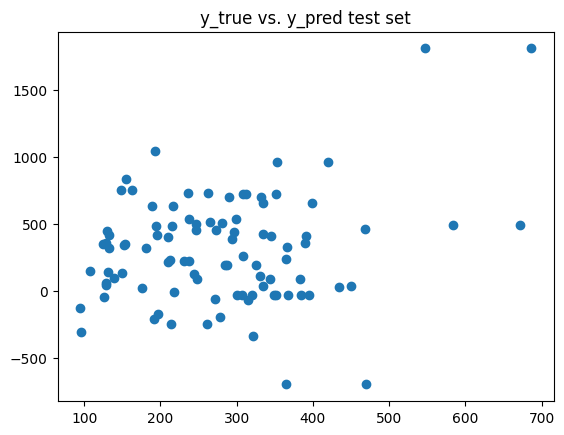

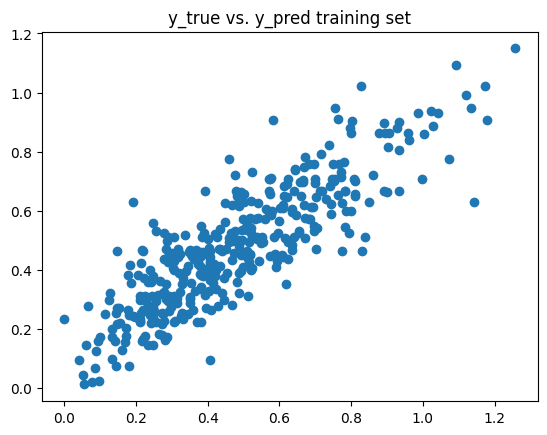

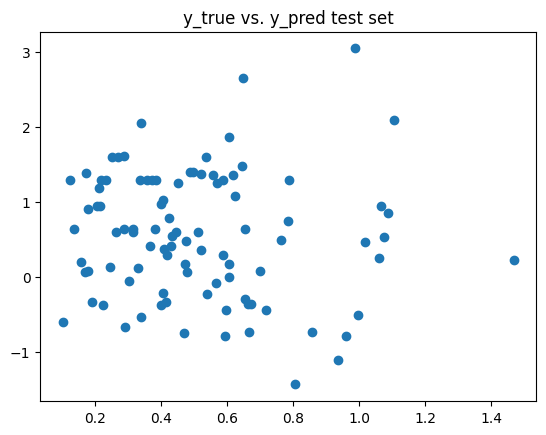

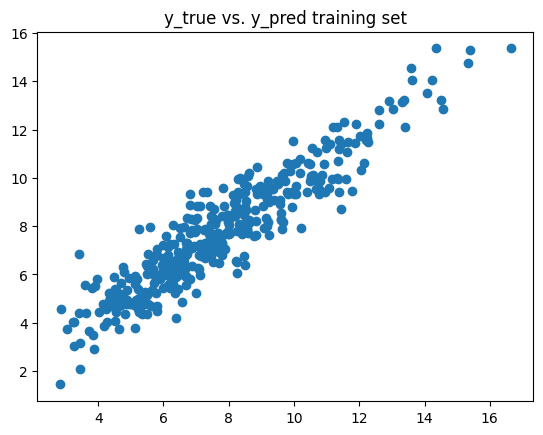

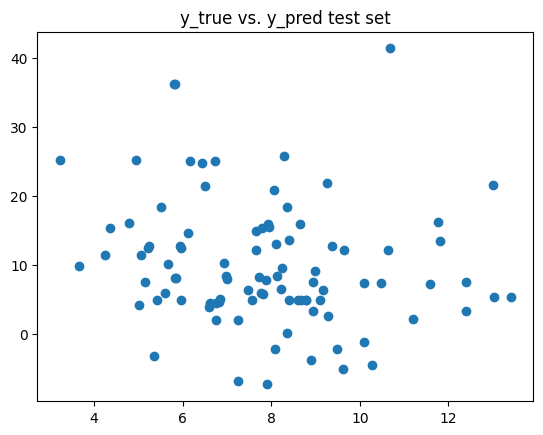

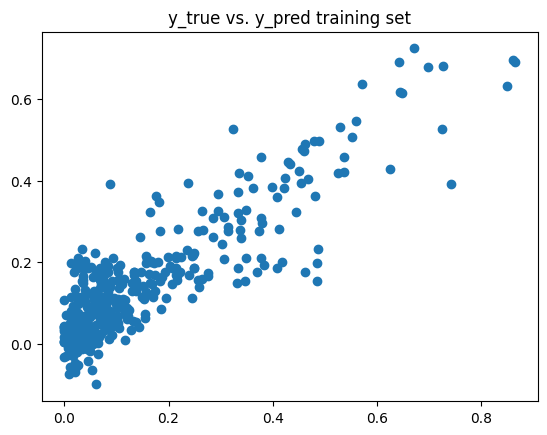

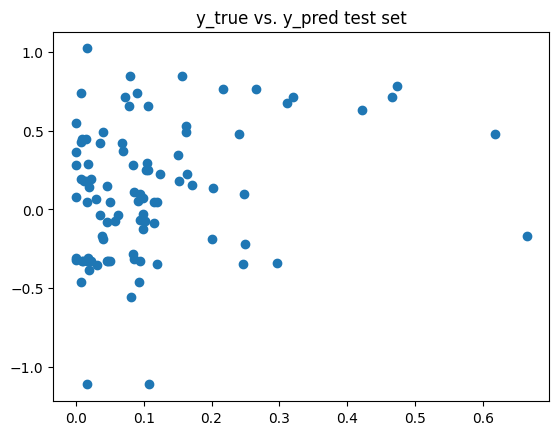

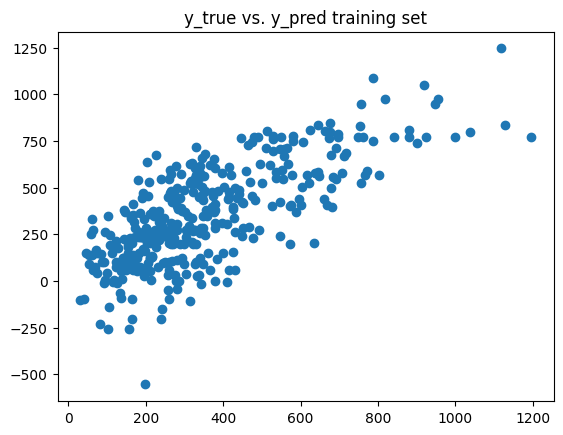

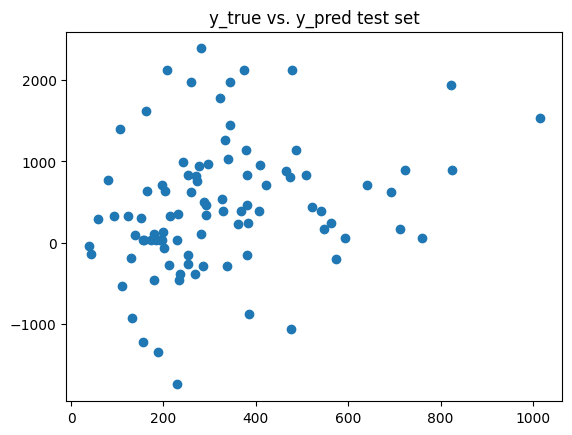

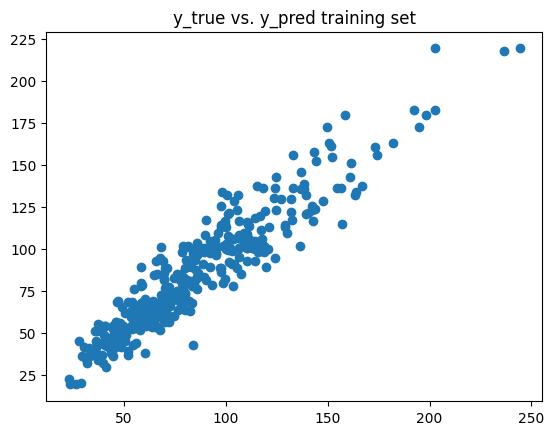

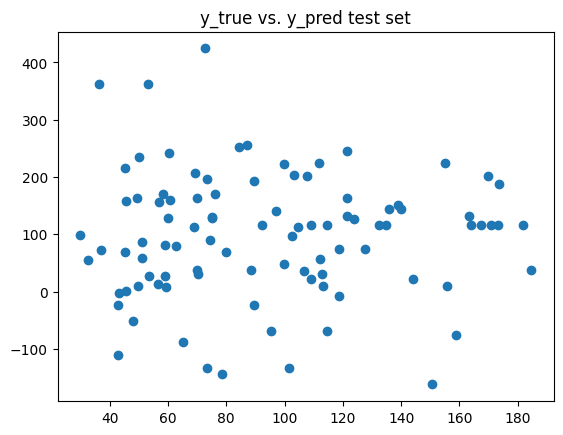

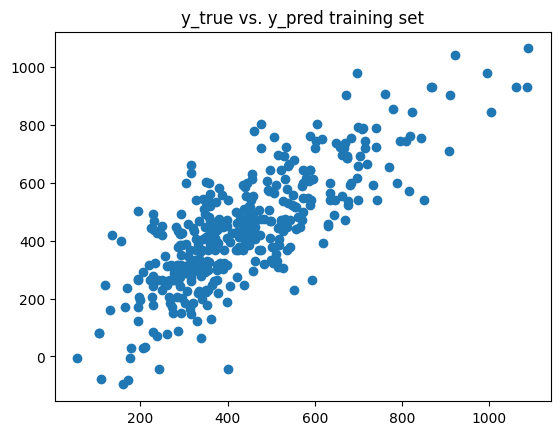

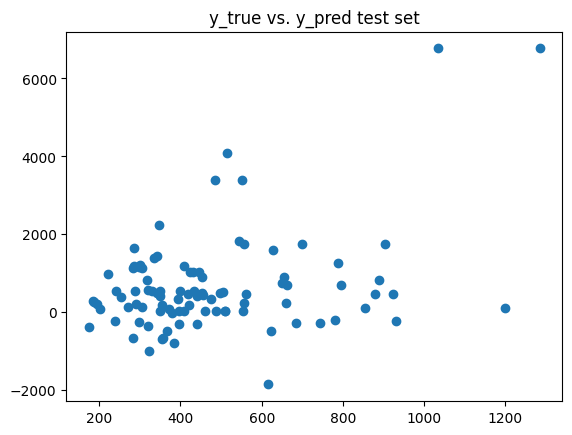

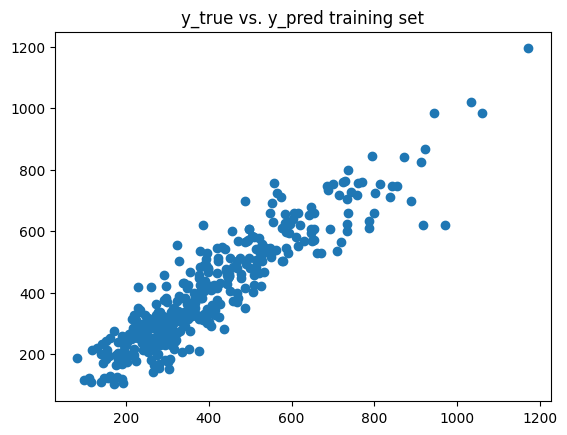

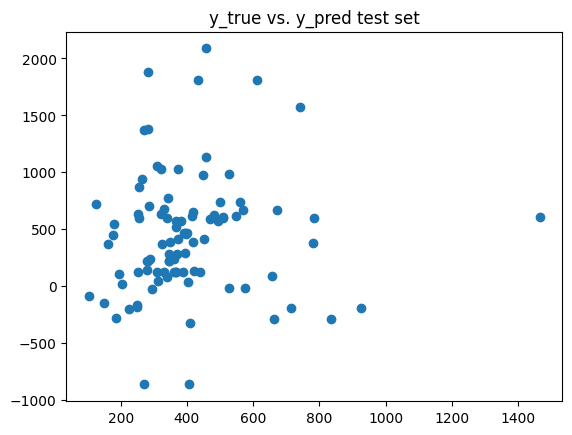

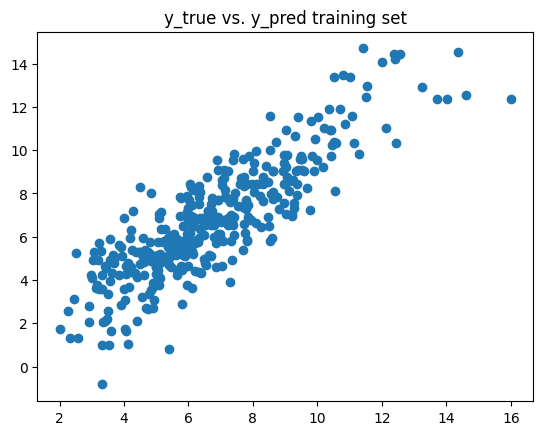

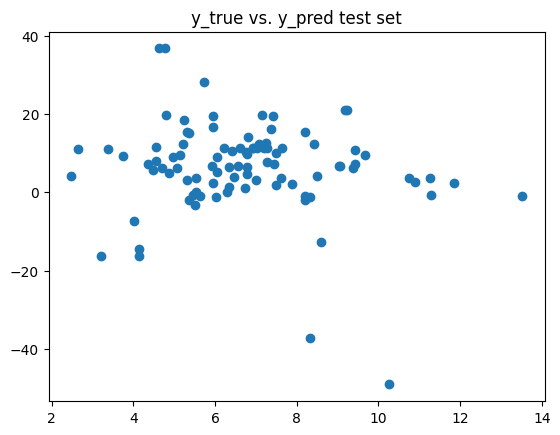

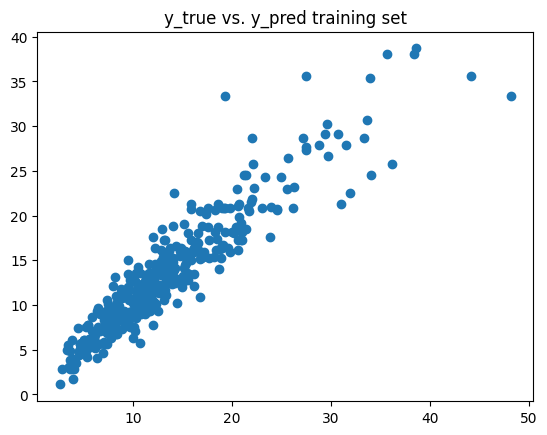

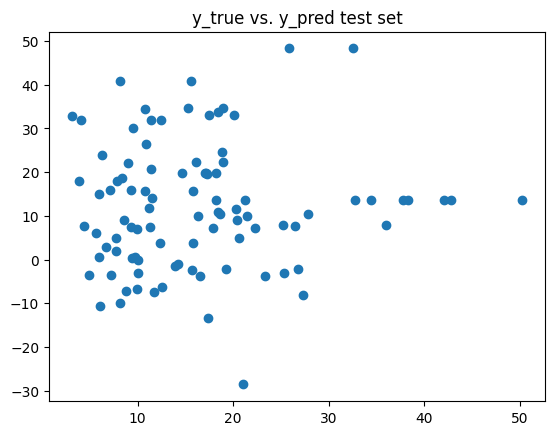

In [38]:
r_values_train = {}
r_values_test = {}
for gene in data.gene_id.unique():
    # extract data
    gene_df = data[data.gene_id == gene]
    gene_df_train = gene_df[~(gene_df.test_set == True)]
    gene_df_test = gene_df[gene_df.test_set == True]
    X_train = np.array(gene_df_train["embedding"].values.tolist())
    X_test = np.array(gene_df_test["embedding"].values.tolist())
    y_train = np.array(gene_df_train.expression)
    y_test = np.array(gene_df_test.expression)
    # run model 
    lr = LinearRegression()
    lr = lr.fit(X_train, y_train)
    r_values_train[gene] = lr.score(X_train, y_train)
    r_values_test[gene] = lr.score(X_test, y_test)
    # plot results on training set 
    y_pred = lr.predict(X_train)
    plt.scatter(y_train, y_pred)
    plt.title("y_true vs. y_pred training set")
    plt.show()
    y_pred = lr.predict(X_test)
    plt.scatter(y_test, y_pred)
    plt.title("y_true vs. y_pred test set")
    plt.show()

In [39]:
r_values_train

{'ENSG00000198502.5': 0.7916112522763181,
 'ENSG00000214425.1': 0.737581726966197,
 'ENSG00000238083.3': 0.8678823530982801,
 'ENSG00000229450.2': 0.7653264868525304,
 'ENSG00000179344.11': 0.2909276011818658,
 'ENSG00000237541.3': 0.8856444656929142,
 'ENSG00000196126.6': 0.5220184861854915,
 'ENSG00000196735.6': 0.8409315574270511,
 'ENSG00000176681.9': 0.6848756294616236,
 'ENSG00000232629.4': 0.866858328216945}

In [40]:
r_values_test

{'ENSG00000198502.5': -10.247941577128778,
 'ENSG00000214425.1': -10.237014093864563,
 'ENSG00000238083.3': -19.645573371023204,
 'ENSG00000229450.2': -9.183693388365574,
 'ENSG00000179344.11': -15.474399758537075,
 'ENSG00000237541.3': -7.147920367977742,
 'ENSG00000196126.6': -28.618934632016806,
 'ENSG00000196735.6': -7.125145246243072,
 'ENSG00000176681.9': -32.816410894805216,
 'ENSG00000232629.4': -2.304892407537335}

### **Compare against SNP predictions**

In [45]:
snp_data = pd.read_csv("/vol/data/ouologuems/systems_genetics/data/datasets/EUR373.gene.cis.FDR5.all.rs137.txt.gz", sep="\t")
snp_data = snp_data[snp_data.GENE_ID.isin(data.gene_id.unique())]
snp_data.GENE_ID = snp_data.GENE_ID.astype('category')
snp_data.head()

,SNP_ID,ID,GENE_ID,PROBE_ID,CHR_SNP,CHR_GENE,SNPpos,TSSpos,distance,rvalue,pvalue,log10pvalue
55450,rs10020034,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120294331.0,120299287,4956.0,0.548974,1.079312e-30,29.966853
55451,rs3955380,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120334410.0,120299287,35123.0,0.547157,1.832933e-30,29.736854
55452,rs28403131,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120285806.0,120299287,13481.0,0.545653,2.834881e-30,29.547465
55453,rs79262354,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120338335.0,120299287,39048.0,0.545126,3.300820e-30,29.481378
55454,rs78958430,-,ENSG00000229450.2,ENSG00000229450.2,4,4,120338339.0,120299287,39052.0,0.544934,3.488677e-30,29.457339


In [54]:
train_df = pd.DataFrame({"gene_id": r_values_train.keys(), "r_values": r_values_train.values()})
test_df = pd.DataFrame({"gene_id": r_values_test.keys(), "r_values": r_values_test.values()})
train_df

,gene_id,r_values
0,ENSG00000198502.5,0.791611
1,ENSG00000214425.1,0.737582
2,ENSG00000238083.3,0.867882
3,ENSG00000229450.2,0.765326
4,ENSG00000179344.11,0.290928
5,ENSG00000237541.3,0.885644
6,ENSG00000196126.6,0.522018
7,ENSG00000196735.6,0.840932
8,ENSG00000176681.9,0.684876
9,ENSG00000232629.4,0.866858


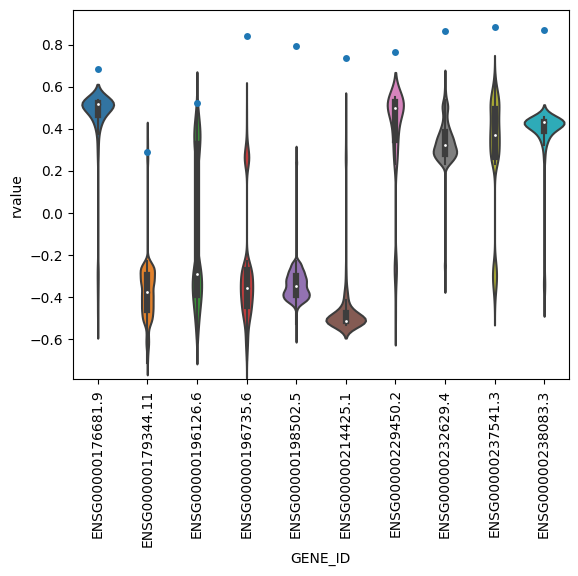

In [56]:
sns.violinplot(x = "GENE_ID", y ="rvalue", data=snp_data.sort_values(by = 'GENE_ID')) 
plt.xticks(rotation=90)
sns.stripplot(x = "gene_id", y ="r_values",data=train_df.sort_values(by = 'gene_id')) 
#sns.stripplot(x = "gene_id", y ="r_values",data=test_df.sort_values(by = 'gene_id'), color="red") 
plt.show() 